# MLP Classification - Bank Marketing Dataset (Optimized)

Complete MLP implementation from scratch with hyperparameter tuning for Kaggle competition.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("Libraries imported successfully")


Libraries imported successfully


## Data Loading and Preprocessing


In [2]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print(f"Target distribution: {train_df['y'].value_counts(normalize=True)}")

# Preprocessing function
def preprocess_data(df, label_encoders=None, scaler=None, is_training=True):
    df_processed = df.copy()
    
    if 'id' in df_processed.columns:
        df_processed = df_processed.drop('id', axis=1)
    
    categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    if is_training:
        label_encoders = {}
        scaler = StandardScaler()
    
    # Encode categorical variables
    for feature in categorical_features:
        if feature in df_processed.columns and feature != 'y':
            if is_training:
                label_encoders[feature] = LabelEncoder()
                df_processed[feature] = label_encoders[feature].fit_transform(df_processed[feature])
            else:
                df_processed[feature] = df_processed[feature].apply(
                    lambda x: x if x in label_encoders[feature].classes_ else label_encoders[feature].classes_[0]
                )
                df_processed[feature] = label_encoders[feature].transform(df_processed[feature])
    
    # Separate features and target
    if 'y' in df_processed.columns:
        X = df_processed.drop('y', axis=1)
        y = df_processed['y'].values
    else:
        X = df_processed
        y = None
    
    # Scale features
    if is_training:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    
    return X_scaled, y, label_encoders, scaler

# Preprocess data
X_processed, y_processed, label_encoders, scaler = preprocess_data(train_df, is_training=True)
print(f"Processed data shape: {X_processed.shape}")


Train shape: (750000, 18), Test shape: (250000, 17)
Target distribution: y
0    0.879349
1    0.120651
Name: proportion, dtype: float64
Processed data shape: (750000, 16)


## MLP Implementation from Scratch


In [3]:
class MLP:
    def __init__(self, input_size, hidden_sizes=[128, 64], learning_rate=0.001, random_seed=42):
        np.random.seed(random_seed)
        self.learning_rate = learning_rate
        self.layers = [input_size] + hidden_sizes + [1]
        
        # Xavier initialization
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            weight = np.random.normal(0, np.sqrt(2.0 / self.layers[i]), (self.layers[i], self.layers[i+1]))
            bias = np.zeros((1, self.layers[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
        
        self.activations = []
        self.z_values = []
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def forward_propagation(self, X):
        self.activations = [X]
        self.z_values = []
        current_activation = X
        
        # Hidden layers with ReLU
        for i in range(len(self.weights) - 1):
            z = np.dot(current_activation, self.weights[i]) + self.biases[i]
            current_activation = self.relu(z)
            self.z_values.append(z)
            self.activations.append(current_activation)
        
        # Output layer with sigmoid
        z_output = np.dot(current_activation, self.weights[-1]) + self.biases[-1]
        output = self.sigmoid(z_output)
        self.z_values.append(z_output)
        self.activations.append(output)
        
        return output
    
    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def backward_propagation(self, X, y_true, y_pred):
        m = X.shape[0]
        weight_gradients = []
        bias_gradients = []
        
        delta = y_pred - y_true.reshape(-1, 1)
        
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.activations[i].T, delta) / m
            db = np.mean(delta, axis=0, keepdims=True)
            
            weight_gradients.insert(0, dW)
            bias_gradients.insert(0, db)
            
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(self.z_values[i-1])
        
        return weight_gradients, bias_gradients
    
    def update_parameters(self, weight_gradients, bias_gradients):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * weight_gradients[i]
            self.biases[i] -= self.learning_rate * bias_gradients[i]
    
    def train_step(self, X_batch, y_batch):
        y_pred = self.forward_propagation(X_batch)
        loss = self.compute_loss(y_batch, y_pred)
        weight_gradients, bias_gradients = self.backward_propagation(X_batch, y_batch, y_pred)
        self.update_parameters(weight_gradients, bias_gradients)
        return loss
    
    def predict_proba(self, X):
        return self.forward_propagation(X)
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int).flatten()

print("MLP class defined successfully")


MLP class defined successfully


## Training Utilities


In [4]:
def create_batches(X, y, batch_size=128, shuffle=True):
    n_samples = X.shape[0]
    if shuffle:
        indices = np.random.permutation(n_samples)
        X, y = X[indices], y[indices]
    
    batches = []
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        batches.append((X[i:end_idx], y[i:end_idx]))
    return batches

def evaluate_model_fast(model, X, y, batch_size=2000):
    """Fast evaluation using batching"""
    predictions = []
    for i in range(0, len(X), batch_size):
        end_idx = min(i + batch_size, len(X))
        batch_pred = model.predict_proba(X[i:end_idx]).flatten()
        predictions.extend(batch_pred)
    
    y_pred_proba = np.array(predictions)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    accuracy = np.mean(y_pred == y)
    auc = roc_auc_score(y, y_pred_proba)
    
    return {'accuracy': accuracy, 'auc': auc, 'probabilities': y_pred_proba}

def train_mlp_fast(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=128, patience=8, verbose=True):
    """Fast training with minimal evaluation"""
    best_val_auc = 0
    patience_counter = 0
    best_weights = None
    best_biases = None
    
    for epoch in range(epochs):
        # Training
        batches = create_batches(X_train, y_train, batch_size=batch_size, shuffle=True)
        epoch_losses = []
        
        for X_batch, y_batch in batches:
            loss = model.train_step(X_batch, y_batch)
            epoch_losses.append(loss)
        
        # Evaluate every 3 epochs
        if (epoch + 1) % 3 == 0 or epoch == 0:
            val_metrics = evaluate_model_fast(model, X_val, y_val)
            
            if verbose:
                print(f"Epoch {epoch+1:2d}: Loss={np.mean(epoch_losses):.4f}, Val AUC={val_metrics['auc']:.4f}")
            
            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                patience_counter = 0
                best_weights = [w.copy() for w in model.weights]
                best_biases = [b.copy() for b in model.biases]
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best weights
    if best_weights is not None:
        model.weights = best_weights
        model.biases = best_biases
    
    return best_val_auc

print("Training utilities defined")


Training utilities defined


## Hyperparameter Tuning


In [5]:
# Split data for hyperparameter tuning
X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y_processed, test_size=0.15, random_state=42, stratify=y_processed)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Hyperparameter configurations to try
configs = [
    {'hidden_sizes': [64], 'learning_rate': 0.001, 'batch_size': 128},
    {'hidden_sizes': [128], 'learning_rate': 0.001, 'batch_size': 128},
    {'hidden_sizes': [128, 64], 'learning_rate': 0.001, 'batch_size': 128},
    {'hidden_sizes': [256, 128], 'learning_rate': 0.001, 'batch_size': 128},
    {'hidden_sizes': [128, 64, 32], 'learning_rate': 0.001, 'batch_size': 128},
    {'hidden_sizes': [128, 64], 'learning_rate': 0.002, 'batch_size': 128},
    {'hidden_sizes': [128, 64], 'learning_rate': 0.0005, 'batch_size': 128},
    {'hidden_sizes': [128, 64], 'learning_rate': 0.001, 'batch_size': 256},
]

print("Starting hyperparameter tuning...")
results = []

for i, config in enumerate(configs):
    print(f"\nConfig {i+1}/{len(configs)}: {config}")
    
    model = MLP(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        learning_rate=config['learning_rate']
    )
    
    val_auc = train_mlp_fast(
        model, X_train, y_train, X_val, y_val,
        epochs=30, batch_size=config['batch_size'], verbose=False
    )
    
    results.append({
        'config': config,
        'val_auc': val_auc,
        'model': model
    })
    
    print(f"Validation AUC: {val_auc:.4f}")

# Find best configuration
best_result = max(results, key=lambda x: x['val_auc'])
print(f"\nBest configuration: {best_result['config']}")
print(f"Best validation AUC: {best_result['val_auc']:.4f}")


Train: 525300, Val: 112200, Test: 112500
Starting hyperparameter tuning...

Config 1/8: {'hidden_sizes': [64], 'learning_rate': 0.001, 'batch_size': 128}
Validation AUC: 0.9331

Config 2/8: {'hidden_sizes': [128], 'learning_rate': 0.001, 'batch_size': 128}
Validation AUC: 0.9340

Config 3/8: {'hidden_sizes': [128, 64], 'learning_rate': 0.001, 'batch_size': 128}
Validation AUC: 0.9387

Config 4/8: {'hidden_sizes': [256, 128], 'learning_rate': 0.001, 'batch_size': 128}
Validation AUC: 0.9420

Config 5/8: {'hidden_sizes': [128, 64, 32], 'learning_rate': 0.001, 'batch_size': 128}
Validation AUC: 0.9408

Config 6/8: {'hidden_sizes': [128, 64], 'learning_rate': 0.002, 'batch_size': 128}
Validation AUC: 0.9423

Config 7/8: {'hidden_sizes': [128, 64], 'learning_rate': 0.0005, 'batch_size': 128}
Validation AUC: 0.9337

Config 8/8: {'hidden_sizes': [128, 64], 'learning_rate': 0.001, 'batch_size': 256}
Validation AUC: 0.9337

Best configuration: {'hidden_sizes': [128, 64], 'learning_rate': 0.002,

## Final Model Training and Evaluation


In [6]:
# Train final model with best configuration
print("Training final model with best hyperparameters...")
best_config = best_result['config']

final_model = MLP(
    input_size=X_train.shape[1],
    hidden_sizes=best_config['hidden_sizes'],
    learning_rate=best_config['learning_rate']
)

# Train with more epochs for final model
final_auc = train_mlp_fast(
    final_model, X_train, y_train, X_val, y_val,
    epochs=50, batch_size=best_config['batch_size'], patience=12, verbose=True
)

# Evaluate on test set
test_results = evaluate_model_fast(final_model, X_test, y_test)
print(f"\nFinal Test Results:")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test AUC: {test_results['auc']:.4f}")

# Confusion Matrix
y_pred_test = (test_results['probabilities'] >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:")
print(cm)
print(f"Precision: {cm[1,1]/(cm[1,1]+cm[0,1]):.4f}")
print(f"Recall: {cm[1,1]/(cm[1,1]+cm[1,0]):.4f}")


Training final model with best hyperparameters...
Epoch  1: Loss=0.5114, Val AUC=0.9130
Epoch  3: Loss=0.5842, Val AUC=0.9254
Epoch  6: Loss=0.6140, Val AUC=0.9319
Epoch  9: Loss=0.6359, Val AUC=0.9351
Epoch 12: Loss=0.6543, Val AUC=0.9372
Epoch 15: Loss=0.6666, Val AUC=0.9386
Epoch 18: Loss=0.6771, Val AUC=0.9397
Epoch 21: Loss=0.6854, Val AUC=0.9405
Epoch 24: Loss=0.6934, Val AUC=0.9412
Epoch 27: Loss=0.6987, Val AUC=0.9418
Epoch 30: Loss=0.7037, Val AUC=0.9423
Epoch 33: Loss=0.7075, Val AUC=0.9428
Epoch 36: Loss=0.7107, Val AUC=0.9433
Epoch 39: Loss=0.7144, Val AUC=0.9437
Epoch 42: Loss=0.7188, Val AUC=0.9441
Epoch 45: Loss=0.7224, Val AUC=0.9444
Epoch 48: Loss=0.7253, Val AUC=0.9448

Final Test Results:
Test Accuracy: 0.9157
Test AUC: 0.9442

Confusion Matrix:
[[95669  3258]
 [ 6230  7343]]
Precision: 0.6927
Recall: 0.5410


## Generate Kaggle Submission


In [7]:
# Preprocess test data
print("Preprocessing test data for submission...")
test_ids = test_df['id'].values
X_test_kaggle, _, _, _ = preprocess_data(test_df, label_encoders, scaler, is_training=False)

print(f"Test data shape: {X_test_kaggle.shape}")

# Generate predictions
print("Generating predictions...")
test_predictions = []
batch_size = 2000

for i in range(0, len(X_test_kaggle), batch_size):
    end_idx = min(i + batch_size, len(X_test_kaggle))
    batch_pred = final_model.predict_proba(X_test_kaggle[i:end_idx]).flatten()
    test_predictions.extend(batch_pred)

# Convert probabilities to binary predictions
test_predictions = np.array(test_predictions)
binary_predictions = (test_predictions >= 0.5).astype(int)

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'y': binary_predictions
})

# Save submission file
submission_df.to_csv('solution.csv', index=False)
print(f"\nSubmission file saved as 'solution.csv'")
print(f"Submission shape: {submission_df.shape}")
print(f"Prediction distribution: {np.bincount(binary_predictions)}")
print(f"Percentage of positive predictions: {np.mean(binary_predictions)*100:.2f}%")

# Show sample of submission
print(f"\nSample of submission file:")
print(submission_df.head(10))


Preprocessing test data for submission...
Test data shape: (250000, 16)
Generating predictions...

Submission file saved as 'solution.csv'
Submission shape: (250000, 2)
Prediction distribution: [226236  23764]
Percentage of positive predictions: 9.51%

Sample of submission file:
       id  y
0  750000  0
1  750001  0
2  750002  0
3  750003  0
4  750004  0
5  750005  0
6  750006  0
7  750007  0
8  750008  0
9  750009  0


## Training Visualization (Optional)


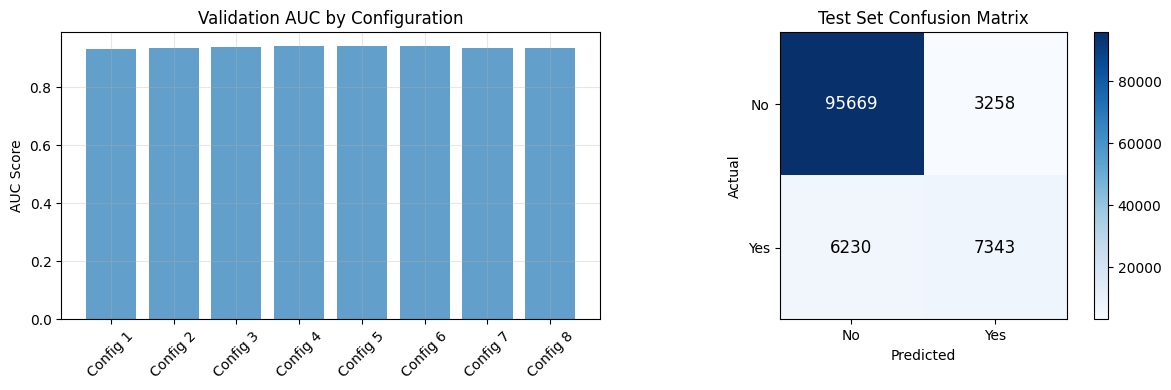


FINAL SUMMARY
Best Architecture: [128, 64]
Best Learning Rate: 0.002
Best Batch Size: 128
Final Test AUC: 0.9442
Final Test Accuracy: 0.9157
Submission file: solution.csv (250,000 predictions)


In [8]:
# Quick visualization of hyperparameter tuning results
plt.figure(figsize=(12, 4))

# Plot 1: AUC scores for different configurations
plt.subplot(1, 2, 1)
aucs = [r['val_auc'] for r in results]
config_labels = [f"Config {i+1}" for i in range(len(results))]
plt.bar(config_labels, aucs, alpha=0.7)
plt.title('Validation AUC by Configuration')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Test set confusion matrix
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Set Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No', 'Yes'])
plt.yticks(tick_marks, ['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=12, color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Architecture: {best_config['hidden_sizes']}")
print(f"Best Learning Rate: {best_config['learning_rate']}")
print(f"Best Batch Size: {best_config['batch_size']}")
print(f"Final Test AUC: {test_results['auc']:.4f}")
print(f"Final Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Submission file: solution.csv ({len(binary_predictions):,} predictions)")
print("="*60)
